<a href="https://colab.research.google.com/github/wendy-guo/floral-garden/blob/main/floral_garden.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt

**Load Dataset** 

Split into 80% for training, 20% for testing.

In [5]:
flower_dataset, dataset_info = tfds.load("tf_flowers", with_info=True, split=['train[:80%]', 'train[80%:]'])
train_set, test_set = flower_dataset
num_training = len(train_set)
num_testing = len(test_set)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


**Get Class Names**

The five classes are daisy, roses, tulips, dandelion, and sunflowers.

In [6]:
flower_names = np.array(dataset_info.features['label'].names)
num_classes = len(flower_names)

**Train Set Examples**

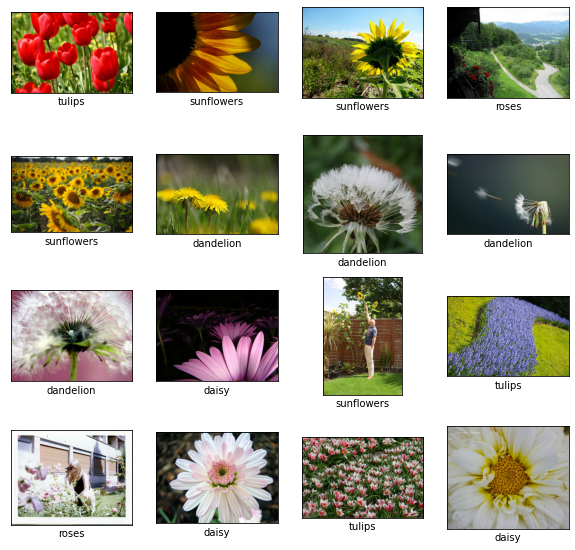

In [7]:
i = 0
plt.figure(figsize=(10, 10))

for item in train_set:
  image, label = item["image"], int(item["label"])
  plt.subplot(4, 4, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image)
  plt.xlabel(flower_names[label])

  i += 1
  if i == 16:
    break

plt.show()

**Format Images and Create Batches**

Resize images to 224x224 for the pre-trained model. Scale rgb values to range of [0, 1]. Create batches of size 32.

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

def format_image(item):
    image, label = item["image"], item["label"]
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE)) # resize
    image /= 255.0 # format
    return (image, label)

train_batches = train_set.shuffle(num_training).map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

**Import Pre-trained Model**

Utilize pre-trained model from TensorFlow Hub to perform transfer learning.

In [9]:
pre_trained_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(pre_trained_model, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
feature_extractor.trainable = False

model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


**Compile Model**

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Train Model**

In [11]:
EPOCHS = 10
model_fit = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=test_batches)

Epoch 1/10
92/92 [==============================] - 94s 958ms/step - loss: 0.7803 - accuracy: 0.7112 - val_loss: 0.4129 - val_accuracy: 0.8760
Epoch 2/10
92/92 [==============================] - 85s 924ms/step - loss: 0.3778 - accuracy: 0.8777 - val_loss: 0.3238 - val_accuracy: 0.8951
Epoch 3/10
92/92 [==============================] - 87s 945ms/step - loss: 0.2955 - accuracy: 0.9046 - val_loss: 0.2914 - val_accuracy: 0.8992
Epoch 4/10
92/92 [==============================] - 87s 945ms/step - loss: 0.2446 - accuracy: 0.9288 - val_loss: 0.2795 - val_accuracy: 0.8992
Epoch 5/10
92/92 [==============================] - 86s 938ms/step - loss: 0.2131 - accuracy: 0.9349 - val_loss: 0.2717 - val_accuracy: 0.8978
Epoch 6/10
92/92 [==============================] - 87s 944ms/step - loss: 0.1851 - accuracy: 0.9465 - val_loss: 0.2764 - val_accuracy: 0.9019
Epoch 7/10
92/92 [==============================] - 86s 931ms/step - loss: 0.1678 - accuracy: 0.9550 - val_loss: 0.2541 - val_accuracy: 0.9087

**Plot Training/Testing Accuracy and Loss**

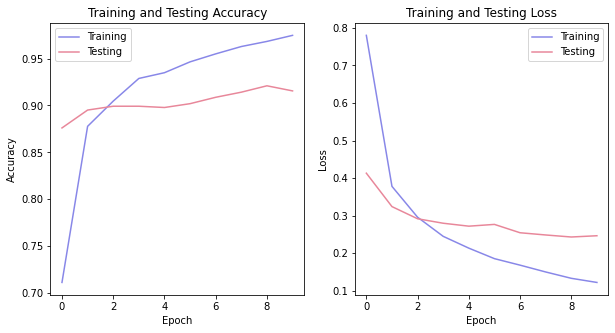

In [19]:
accuracy = model_fit.history["accuracy"]
val_accuracy = model_fit.history["val_accuracy"]
loss = model_fit.history["loss"]
val_loss = model_fit.history["val_loss"]

epochs_range = range(EPOCHS)
colour_1 = "#8887e8"
colour_2 = "#e8879a"

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label="Training", color=colour_1)
plt.plot(epochs_range, val_accuracy, label="Testing", color=colour_2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.title("Training and Testing Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training", color=colour_1)
plt.plot(epochs_range, val_loss, label="Testing", color=colour_2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Training and Testing Loss")

plt.show()

**Create Batches for Predictions**

In [23]:
image_batch, label_batch = next(iter(train_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)

**Model Predictions**

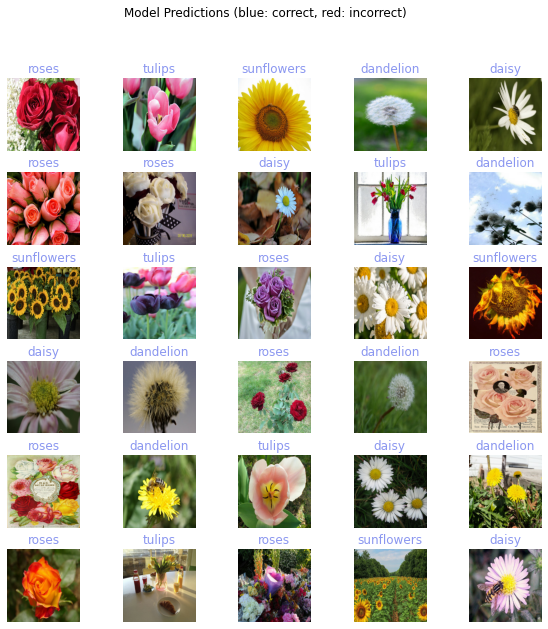

In [24]:
plt.figure(figsize=(10, 10))
class_names = np.array(dataset_info.features['label'].names)

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])

    if predicted_ids[n] == label_batch[n]:
      colour = "#8b97f0" 
    else:
      colour = "#e87482"

    plt.title(flower_names[predicted_ids[n]], color=colour)
    plt.axis('off')
_ = plt.suptitle("Model Predictions (blue: correct, red: incorrect)")